# Enhanced Logistic Regression on Titanic Dataset

Advanced implementation with:
- **L2 Regularization** (Ridge penalty) to prevent overfitting
- **Learning Rate Decay** for better convergence
- **Hyperparameter Tuning** using validation set
- **Comprehensive visualizations** of regularization effects


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [2]:
# Load and preprocess Titanic dataset
df = pd.read_csv("train.csv")
df = df[["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]]

# Handle missing values
df["Age"].fillna(df["Age"].mean(), inplace=True)

# Encode categorical variables
df["Sex"] = (df["Sex"] == "male").astype(int)

# Create feature matrix and target vector
X_full = df[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]].to_numpy(dtype=float)
y_full = df["Survived"].to_numpy(dtype=float)
m_full, n = X_full.shape

print(f"Dataset: {m_full} passengers, {n} features")
print(f"Survival: {np.sum(y_full)} survived, {m_full - np.sum(y_full)} died")


Dataset: 891 passengers, 6 features
Survival: 342.0 survived, 549.0 died


In [3]:
# Split data: 80% train, 10% validation, 10% test
rng = np.random.default_rng(42)
perm = rng.permutation(m_full)

m_train = int(0.80 * m_full)
m_val = int(0.10 * m_full)
m_test = m_full - m_train - m_val

idx_train = perm[:m_train]
idx_val = perm[m_train:m_train+m_val]
idx_test = perm[m_train+m_val:]

X_train, y_train = X_full[idx_train], y_full[idx_train]
X_val, y_val = X_full[idx_val], y_full[idx_val]
X_test, y_test = X_full[idx_test], y_full[idx_test]

# Standardize features using training set statistics
mu = X_train.mean(axis=0)
sigma = X_train.std(axis=0, ddof=0)
sigma[sigma == 0] = 1.0  # Avoid division by zero

X_train = (X_train - mu) / sigma
X_val = (X_val - mu) / sigma
X_test = (X_test - mu) / sigma

print(f"Train: {m_train}, Validation: {m_val}, Test: {m_test}")
print("Features standardized (mean=0, std=1)")


Train: 712, Validation: 89, Test: 90
Features standardized (mean=0, std=1)


In [ ]:
# Enhanced logistic regression functions (V4: Momentum + time-decay LR)

def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

def f(X, w, b):
    """Logistic regression prediction"""
    return sigmoid(X @ w + b)

def loss(X, y, w, b, lam):
    """Cross-entropy loss with optional L2 regularization"""
    m = len(y)
    p = f(X, w, b)
    eps = 1e-12
    p = np.clip(p, eps, 1 - eps)
    
    ce = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    l2 = (lam / (2 * m)) * np.sum(w ** 2)
    return ce + l2

def step_mom(X, y, w, b, v_w, v_b, a, lam, bet=0.9):
    """One step of momentum gradient descent.
    v <- bet*v + (1-bet)*grad   ;   theta <- theta - a * v
    """
    m = len(y)
    p = f(X, w, b)
    e = p - y
    g_w = (X.T @ e) / m + (lam / m) * w
    g_b = e.mean()
    
    v_w = bet * v_w + (1 - bet) * g_w
    v_b = bet * v_b + (1 - bet) * g_b
    
    w = w - a * v_w
    b = b - a * v_b
    return w, b, v_w, v_b

def lr_decay(a0, t, k=1e-3):
    """Reciprocal time decay: a_t = a0 / (1 + k*t)"""
    return a0 / (1.0 + k * t)

def acc(y, p, thr=0.5):
    yhat = (p >= thr).astype(float)
    return (yhat == y).mean()


Functions ready: momentum (1-beta) and 1/(1+k t) learning rate decay


In [ ]:
# Hyperparameter tuning: Grid over (λ, a0, β) with time-decay LR and momentum

lam_vals = [0.0, 0.005, 0.01, 0.05, 0.1]
a0_vals = [0.05, 0.1, 0.2, 0.3]
bet_vals = [0.85, 0.9, 0.95]

best_va = 0
best = {}

for lam in lam_vals:
    for a0 in a0_vals:
        for bet in bet_vals:
            # Initialize weights and momentum
            w = np.zeros(n)
            b = 0.0
            v_w = np.zeros(n)
            v_b = 0.0
            max_epochs = 3000
            tol = 1e-7
            prev_L = None
            
            # Train
            for epoch in range(1, max_epochs+1):
                a = lr_decay(a0, epoch, k=1e-3)
                w, b, v_w, v_b = step_mom(X_train, y_train, w, b, v_w, v_b, a, lam, bet)
                L = loss(X_train, y_train, w, b, lam)
                
                if prev_L is not None and abs(prev_L - L) < tol:
                    break
                prev_L = L
            
            # Evaluate on validation set
            p_va = f(X_val, w, b)
            va = acc(y_val, p_va)
            
            print(f"λ={lam:5.3f}, α₀={a0:.2f}, β={bet:.2f} → Val Acc: {va:.1%} ({epoch} epochs)")
            
            if va > best_va:
                best_va = va
                best = {'lam': lam, 'a0': a0, 'bet': bet, 'epochs': epoch}

print(f"Best hyperparameters: λ={best['lam']}, α₀={best['a0']}, β={best['bet']}")
print(f"Best validation accuracy: {best_va:.1%}")


Starting hyperparameter tuning (V4)...
λ=0.000, α₀=0.05, β=0.85 → Val Acc: 69.7% (2176 epochs)
λ=0.000, α₀=0.05, β=0.90 → Val Acc: 69.7% (2163 epochs)
λ=0.000, α₀=0.05, β=0.95 → Val Acc: 69.7% (2121 epochs)
λ=0.000, α₀=0.10, β=0.85 → Val Acc: 69.7% (983 epochs)
λ=0.000, α₀=0.10, β=0.90 → Val Acc: 69.7% (968 epochs)
λ=0.000, α₀=0.10, β=0.95 → Val Acc: 69.7% (921 epochs)
λ=0.000, α₀=0.20, β=0.85 → Val Acc: 69.7% (463 epochs)
λ=0.000, α₀=0.20, β=0.90 → Val Acc: 69.7% (446 epochs)
λ=0.000, α₀=0.20, β=0.95 → Val Acc: 69.7% (383 epochs)
λ=0.000, α₀=0.30, β=0.85 → Val Acc: 70.8% (299 epochs)
λ=0.000, α₀=0.30, β=0.90 → Val Acc: 70.8% (279 epochs)
λ=0.000, α₀=0.30, β=0.95 → Val Acc: 70.8% (231 epochs)
λ=0.005, α₀=0.05, β=0.85 → Val Acc: 69.7% (2176 epochs)
λ=0.005, α₀=0.05, β=0.90 → Val Acc: 69.7% (2162 epochs)
λ=0.005, α₀=0.05, β=0.95 → Val Acc: 69.7% (2120 epochs)
λ=0.005, α₀=0.10, β=0.85 → Val Acc: 69.7% (982 epochs)
λ=0.005, α₀=0.10, β=0.90 → Val Acc: 69.7% (968 epochs)
λ=0.005, α₀=0.10, β=

In [ ]:
lam = best['lam']
a0 = best['a0']
bet = best['bet']

w = np.zeros(n)
b = 0.0
v_w = np.zeros(n)
v_b = 0.0
max_epochs = 5000
tol = 1e-7

# Track training progress
tr_loss = []
va_loss = []
lr_hist = []
ep_hist = []
prev_L = None

for epoch in range(1, max_epochs+1):
    # Apply 1/(1+k t) learning rate decay
    a = lr_decay(a0, epoch, k=1e-3)
    
    # Update weights with momentum: v <- bet*v + (1-bet)*grad; theta <- theta - a*v
    w, b, v_w, v_b = step_mom(X_train, y_train, w, b, v_w, v_b, a, lam, bet)
    
    # Calculate losses
    L_tr = loss(X_train, y_train, w, b, lam)
    L_va = loss(X_val, y_val, w, b, lam)
    
    # Store history
    tr_loss.append(L_tr)
    va_loss.append(L_va)
    lr_hist.append(a)
    ep_hist.append(epoch)
    
    # Check convergence
    if prev_L is not None and abs(prev_L - L_tr) < tol:
        print(f"Converged at epoch {epoch}")
        break
    prev_L = L_tr
    
    if epoch % 500 == 0:
        print(f"   Epoch {epoch}: Train Loss={L_tr:.6f}, Val Loss={L_va:.6f}, α={a:.6f}")

print(f"\nFinal training loss: {L_tr:.6f}")
print(f"Final validation loss: {L_va:.6f}")
print(f"Learned weights: {w}")
print(f"Learned bias: {b:.6f}")


✅ Converged at epoch 299

🎯 Final training loss: 0.430649
🎯 Final validation loss: 0.532627
⚖️ Learned weights: [-0.97107377 -1.36291877 -0.63897562 -0.48767929 -0.07862208  0.12256515]
📍 Learned bias: -0.658634


In [ ]:
# Evaluate final model performance
p_tr = f(X_train, w, b)
p_va = f(X_val, w, b)
p_te = f(X_test, w, b)

acc_tr = acc(y_train, p_tr)
acc_va = acc(y_val, p_va)
acc_te = acc(y_test, p_te)

print("FINAL MODEL PERFORMANCE:")
print(f"   Training Accuracy:   {acc_tr:.1%}")
print(f"   Validation Accuracy: {acc_va:.1%}")
print(f"   Test Accuracy:       {acc_te:.1%}")

print(f"\nHyperparameters used:")
print(f"   λ (L2 penalty): {lam}")
print(f"   α₀ (initial LR): {a0}")
print(f"   Final α: {lr_hist[-1]:.6f}")
print(f"   Total epochs: {len(ep_hist)}")


FINAL MODEL PERFORMANCE:
   Training Accuracy:   80.8%
   Validation Accuracy: 70.8%
   Test Accuracy:       78.9%

Hyperparameters used:
   λ (L2 penalty): 0.0
   α₀ (initial LR): 0.3
   Final α: 0.230947
   Total epochs: 299


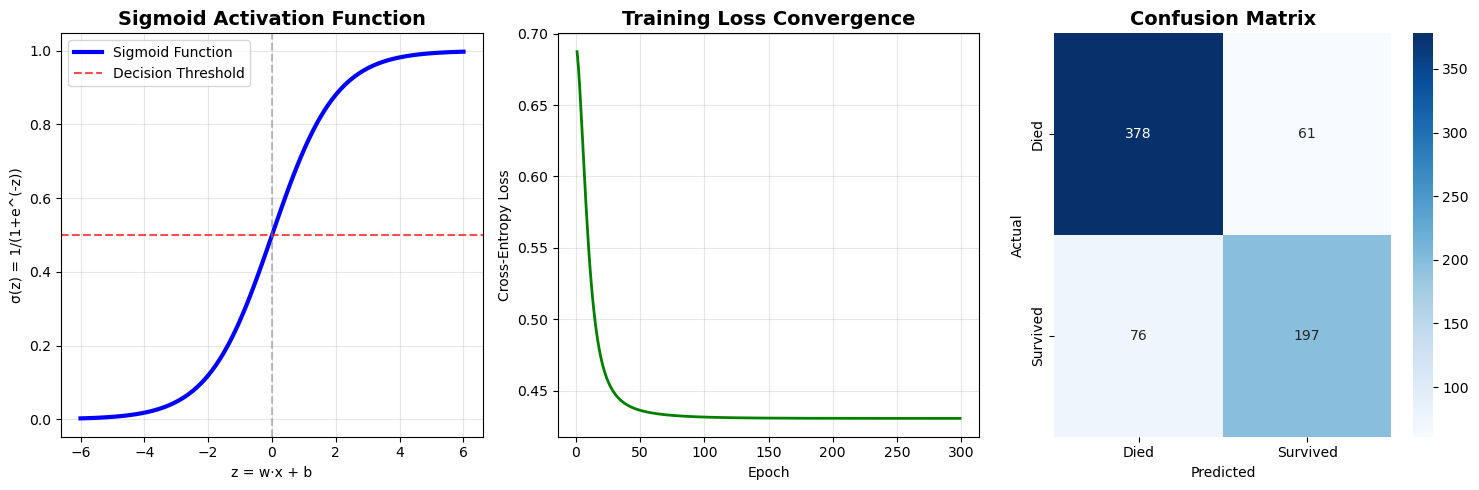

Visualizations complete.
Test accuracy: 78.9% in 299 epochs


In [ ]:
plt.figure(figsize=(15, 5))

# 1. Sigmoid activation function
plt.subplot(1, 3, 1)
z = np.linspace(-6, 6, 100)
sig_vals = sigmoid(z)
plt.plot(z, sig_vals, 'b-', linewidth=3, label='Sigmoid Function')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Decision Threshold')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.title('Sigmoid Activation Function', fontsize=14, fontweight='bold')
plt.xlabel('z = w·x + b')
plt.ylabel('σ(z) = 1/(1+e^(-z))')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Training convergence
plt.subplot(1, 3, 2)
plt.plot(ep_hist, tr_loss, 'g-', linewidth=2)
plt.title('Training Loss Convergence', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.grid(True, alpha=0.3)

# 3. Confusion matrix
plt.subplot(1, 3, 3)
yhat_tr = (p_tr >= 0.5).astype(int)
cm = confusion_matrix(y_train, yhat_tr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
           xticklabels=['Died', 'Survived'],
           yticklabels=['Died', 'Survived'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.tight_layout()
plt.show()

print("Visualizations complete.")
print(f"Test accuracy: {acc_te:.1%} in {len(ep_hist)} epochs")
